<h1 style='color:#1a2f40'>Individual Price Optimization</h1>

- conda environment: generalml_p311_cpu_x86_64_v1
- Author: Assaf Rabinowicz
- Date: 29Dec2025 

# Probelm Description

1. The goal of this project is to maximize portfolio profit by selecting optimal prices ($p_1,...,p_n$).\
$$ profit_i= demand(p_i)(p_i-cost)$$\
$$p^{*}_1,...,p^{*}_n=\argmax_{p_1,...,p_n} \, \sum_i profit_i$$\
2. The optimization process includes two types of constraints:
    *  Global constraint: maintaining average demand at 65%. 
    $$\sum_i demand(p^{*}_i)/n=0.65$$
    *  Individual constraints: bounding prices within a fixed range (2 to 6). 
    $$2<=p^{*}_i<=6, \forall i$$
3. The optimization relies on a demand model, that predicts the purchase probability given a set of features, including the price.
4. After solving the optimization problem, an automated process which does batch optimization for new cases given the optimzation results is required.

# Packages Import

In [9]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize_scalar, root_scalar
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

import ads
from ads import set_auth
from ads.jobs import Job, DataScienceJob, PythonRuntime
from ads.common.model_metadata import UseCaseType
from ads.model.framework.sklearn_model import SklearnModel
import oci
from oci.object_storage import UploadManager

  from ads.common.model_metadata import UseCaseType



In [10]:
ads.set_auth("resource_principal") # a signer for all ads operations, managed automatically
signer = oci.auth.signers.get_resource_principals_signer()

# Demand Model Fitting

## Modeling 

In [2]:
df_demand=pd.read_csv('./data/price_opt_data_1000.csv')
X = df_demand[["price", "age", "risk"]]
y = df_demand["purchase"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1
)

In [3]:
model = LogisticRegression(solver="lbfgs", max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

## Model Analysis

In [4]:
print(model.coef_[0])

[-1.45696918  0.04861314 -1.38003929]


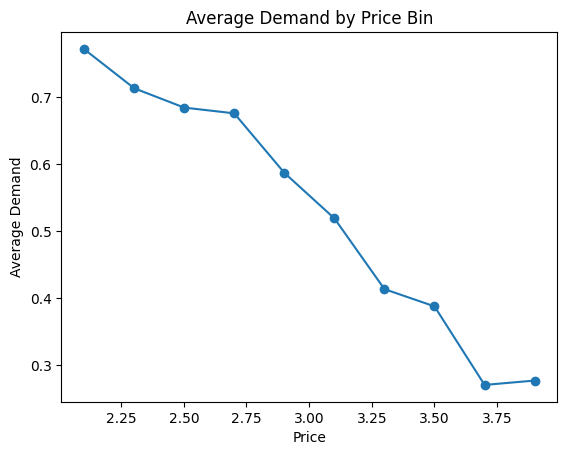

In [5]:
df = df_demand.copy()

df["price_bin"] = pd.cut(df["price"], bins=10)

avg_demand = df.groupby("price_bin",observed=True)["purchase"].mean()

price_mid = [interval.mid for interval in avg_demand.index]

plt.figure()
plt.plot(price_mid, avg_demand.values, marker="o")
plt.xlabel("Price")
plt.ylabel("Average Demand")
plt.title("Average Demand by Price Bin")
plt.show()

In [6]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.58      0.65       144
           1       0.68      0.81      0.74       156

    accuracy                           0.70       300
   macro avg       0.71      0.70      0.69       300
weighted avg       0.71      0.70      0.70       300



# Optimization

* Multi-dimensional optimization problem using Lagrangian method ($p_1,...,p_n, \lambda$)
* Direct solution is complex, therefore it is simplified into two nested optimization problems:
    * Outer loop: optimize $\lambda$
    * Inner loop: optimize $p_1,...,p_n$ given $\lambda$
* Outer loop: root-finding on the constraint function (which is the derivative of the Lagrangian by $\lambda$
* Inner loop: iterate over each $p_i$ and apply Brent’s method
    * It is a derivative-free line search, and therefore also suitable when the derivatives are unknown.
    * Parallelizable, since given lambda the prices are independent.

## Optimization parameters

In [7]:
#Global constraint:
target_avg_demand = 0.6

# Ind. constraints
p_min = 2
p_max = 6

# A unified cost for all customers
cost = 2

## Inner optimization functions

In [8]:
def inner_objective(price, age, risk, lam):
    X_tmp = pd.DataFrame([[price, age, risk]], columns=['price', 'age', 'risk'])
    d = model.predict_proba(X_tmp)[0, 1]
    return -(d * (price - cost) + lam * d)

In [9]:
def optimal_price(age, risk, lam):
    res = minimize_scalar(
        inner_objective,
        bounds=(p_min, p_max),
        args=(age, risk, lam),
        method="bounded",
        options={"xatol": 1e-4}
    )
    return res.x

## Outer opimization functions

In [10]:
def global_constraint_check(lam):
    ages = X["age"].values
    risks = X["risk"].values
    
    # Compute optimal prices for all individuals
    prices = np.array([optimal_price(a, r, lam) for a, r in zip(ages, risks)])
    
    # Create DataFrame with proper column names
    X_tmp = X.copy()
    X_tmp['price'] = prices
    
    # Predict expected demand using the logistic regression model
    demands = model.predict_proba(X_tmp)[:, 1]
    print(f"lambda: {lam}  demand:{demands.mean()}")
    # Return deviation from target average demand
    return demands.mean() - target_avg_demand


In [11]:
def find_bracket(f, start=0, initial_step=0.5, max_iter=10):
    a = start
    fa = f(a)
    step = initial_step
    
    for k in range(max_iter):
        b = a + step
        fb = f(b)
        
        if fa * fb < 0:
            return a, b
        
        # Expand search exponentially
        a = b
        fa = fb
        step *= 2  # Double step size each iteration
    
    raise ValueError("Could not find bracket")


In [12]:
try:
    a, b = find_bracket(global_constraint_check, initial_step=0.5)
    print(f"brackets: ({a},{b})")
    res = root_scalar(
        global_constraint_check,
        bracket=(a, b),
        method="brentq",
        xtol=1e-4
    )
    lambda_star = res.root
    print(f"Optimal lambda: {lambda_star}")
except ValueError as e:
    print(f"Error: {e}")
    print("Try adjusting start/step in find_bracket or check if solution exists")

lambda: 0  demand:0.44639438864357156
lambda: 0.5  demand:0.534719892870319
lambda: 1.5  demand:0.6685762365603668
brackets: (0.5,1.5)
lambda: 0.5  demand:0.534719892870319
lambda: 1.5  demand:0.6685762365603668
lambda: 0.9876878101559453  demand:0.6074264982382986
lambda: 0.9378737300647034  demand:0.6006461621116643
lambda: 0.933173006217308  demand:0.599998777078217
lambda: 0.9332230062173085  demand:0.6000056671969027
Optimal lambda: 0.933173006217308


## Analysis

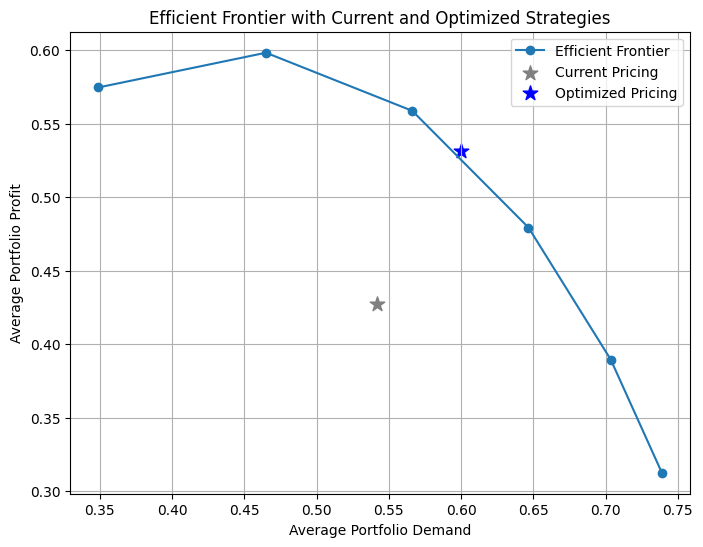

In [15]:
lambdas = np.linspace(a-1, b+1, 6)

avg_demands = []
avg_profits = []

for lam in lambdas:
    prices = np.array([
        optimal_price(X.loc[i, "age"], X.loc[i, "risk"], lam)
        for i in X.index
    ])
    
    X_tmp = X.copy()
    X_tmp["price"] = prices
    
    demands = model.predict_proba(X_tmp)[:, 1]
    
    profits = demands * (prices - cost)
    
    avg_demands.append(demands.mean())
    avg_profits.append(profits.mean())


current_avg_demand = df["purchase"].mean()
current_avg_profit = (df["purchase"] * (df["price"] - cost)).mean()

prices_star = np.array([
    optimal_price(X.loc[i, "age"], X.loc[i, "risk"], lambda_star)
    for i in X.index
])

X_star = X.copy()
X_star["price"] = prices_star

demands_star = model.predict_proba(X_star)[:, 1]
profits_star = demands_star * (prices_star - cost)

new_avg_demand = demands_star.mean()
new_avg_profit = profits_star.mean()

plt.figure(figsize=(8, 6))

# Efficient frontier
plt.plot(
    avg_demands,
    avg_profits,
    marker="o",
    label="Efficient Frontier"
)

# Current performance
plt.scatter(
    current_avg_demand,
    current_avg_profit,
    color="gray",
    s=120,
    marker="*",
    label="Current Pricing"
)

# New strategy
plt.scatter(
    new_avg_demand,
    new_avg_profit,
    color="blue",
    s=120,
    marker="*",
    label="Optimized Pricing"
)

plt.xlabel("Average Portfolio Demand")
plt.ylabel("Average Portfolio Profit")
plt.title("Efficient Frontier with Current and Optimized Strategies")
plt.legend()
plt.grid(True)
plt.show()

## Optimal prices for new cases

In [16]:
def optimal_price_for_customer(age, risk):
    return optimal_price(age, risk, lambda_star)


In [17]:
new_age = 45
new_risk = 0.2

price = optimal_price_for_customer(new_age, new_risk)
print("Optimal price:", price)


Optimal price: 3.012667038843836


# Productization

## Model Deployment

In [11]:
demand_model_serialized = SklearnModel(estimator=model, artifact_dir="demand_model_artifacts_1")
conda_env="generalml_p311_cpu_x86_64_v1"
demand_model_serialized.prepare(
    inference_conda_env=conda_env,
    training_conda_env=conda_env,
    X_sample=X_test,
    y_sample=y_test,
    use_case_type=UseCaseType.BINARY_CLASSIFICATION,
    force_overwrite=True
)

                                                                                                                                                                                                                                                                                   ?, ?it/s]

algorithm: LogisticRegression
artifact_dir:
  /home/datascience/code/operational_research/individual_optimization/demand_model_artifacts_2:
  - - .model-ignore
    - score.py
    - model.joblib
    - test_json_output.json
    - output_schema.json
    - runtime.yaml
    - input_schema.json
framework: scikit-learn
model_deployment_id: null
model_id: null

In [12]:
demand_model_serialized.summary_status()

Actions Needed
Step      Status        Details                                                           
initiate  Done          Initiated the model                                               
prepare() Done          Generated runtime.yaml                                            
                        Generated score.py                                                
                        Serialized model                                                  
                        Populated metadata(Custom, Taxonomy and Provenance)               
verify()  Available     Local tested .predict from score.py                               
save()    Available     Conducted Introspect Test                                         
                        Uploaded artifact to model catalog                                
deploy()  UNKNOWN       Deployed the model                                                
predict() Not Available Called deployment predict endpoint

In [13]:
demand_model_serialized.verify(X_test.iloc[:20], auto_serialize_data=True)

Start loading model.joblib from model directory /home/datascience/code/operational_research/individual_optimization/demand_model_artifacts_2 ...
Model is successfully loaded.
  return pd.read_json(json_data, dtype=fetch_data_type_from_schema(input_schema_path))



{'prediction': [0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1]}

In [15]:
demand_model_serialized.save(display_name="demand model, ind optimization 1")

Start loading model.joblib from model directory /home/datascience/code/operational_research/individual_optimization/demand_model_artifacts_2 ...
Model is successfully loaded.
['.model-ignore', 'score.py', 'model.joblib', 'test_json_output.json', 'output_schema.json', 'runtime.yaml', 'input_schema.json']


loop1:   0%|          | 0/4 [00:00<?, ?it/s]

'ocid1.datasciencemodel.oc1.eu-frankfurt-1.amaaaaaaeicj2tiayhoydfvojqx4ogzhut2eyezaif5tcndqnxr3zw4gik2q'

In [16]:
demand_model_serialized.deploy(display_name="demand model, ind optimization 1")

## Saving parameters in a bucket 

In [8]:
object_storage = oci.object_storage.ObjectStorageClient({}, signer=signer)
namespace = object_storage.get_namespace().data

bucket_name = "filesdemo"
object_name = "operational_research/optimization_parameters.txt"

params_dict = {
    "lambda_star": lambda_star,
    "cost": cost,
    "p_min": p_min,
    "p_max": p_max
}

params_txt = str(params_dict)

object_storage.put_object(
    namespace_name=namespace,
    bucket_name=bucket_name,
    object_name=object_name,
    put_object_body=params_txt
)

## Job Automation

In [11]:
job = (
    Job(name="price_optimization_new_cases")
    .with_infrastructure(
        DataScienceJob()
        .with_log_group_id("<your group id>")
        .with_shape_name("VM.Standard.E4.Flex")
        .with_shape_config_details(memory_in_gbs=4, ocpus=1)
        .with_block_storage_size(50) # minimus is 50
    )
    .with_runtime(
        PythonRuntime()
        .with_service_conda("generalml_p311_cpu_x86_64_v1")
        .with_source("/home/datascience/code/operational_research/individual_optimization/job_script.ipynb")
    )
)

In [12]:
job.create()

In [13]:
# Start a job run
run = job.run()
# Stream the job run outputs
run.watch()